## 초기 정리 파일

- 공포탐욕지수의 가능성에 대한 poc 진행

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter

## data load

In [3]:
# # minio client 생성
# from minio import Minio

# client = Minio(
#     "192.168.0.20:8801",  # URIk
#     access_key="minioadmin",
#     secret_key="minioadmin",
#     secure=False)


In [4]:
# # bucket 내 모든 object 리스트 확인
# objects = client.list_objects("stock-dataset", prefix="/", recursive=True)
# for obj in objects:
#     print(obj.object_name, obj.size)
    

In [5]:
# result = client.fget_object("stock-dataset","ETF/kodex200.csv","/workspace/kiwoomAPI/kodex200.csv")

## data EDA
- 데이터 : kodex200.csv
- 추출일자 : 2002.10.14 ~ 2022.08.25

In [6]:
import os

In [7]:
os.getcwd()

'/data/workspace/taehoon/demo-web-application/FGindex/EDA'

In [8]:
kodex = pd.read_csv("/data/workspace/taehoon/demo-web-application/FGindex//DATA/kodex200.csv")
kodex.columns = ["date","open","high","low","close","volume"]
kodex = kodex.sort_values("date").reset_index(drop=True)

In [9]:
from datetime import date

def int2date(argdate: int) -> date:
    year = int(argdate / 10000)
    month = int((argdate % 10000) / 100)
    day = int(argdate % 100)
    return date(year, month, day)

datetime_list = [int2date(i) for i in kodex.date]

In [10]:
kodex["datetime"] = datetime_list

  - close : 종가
  - volume : 거래량

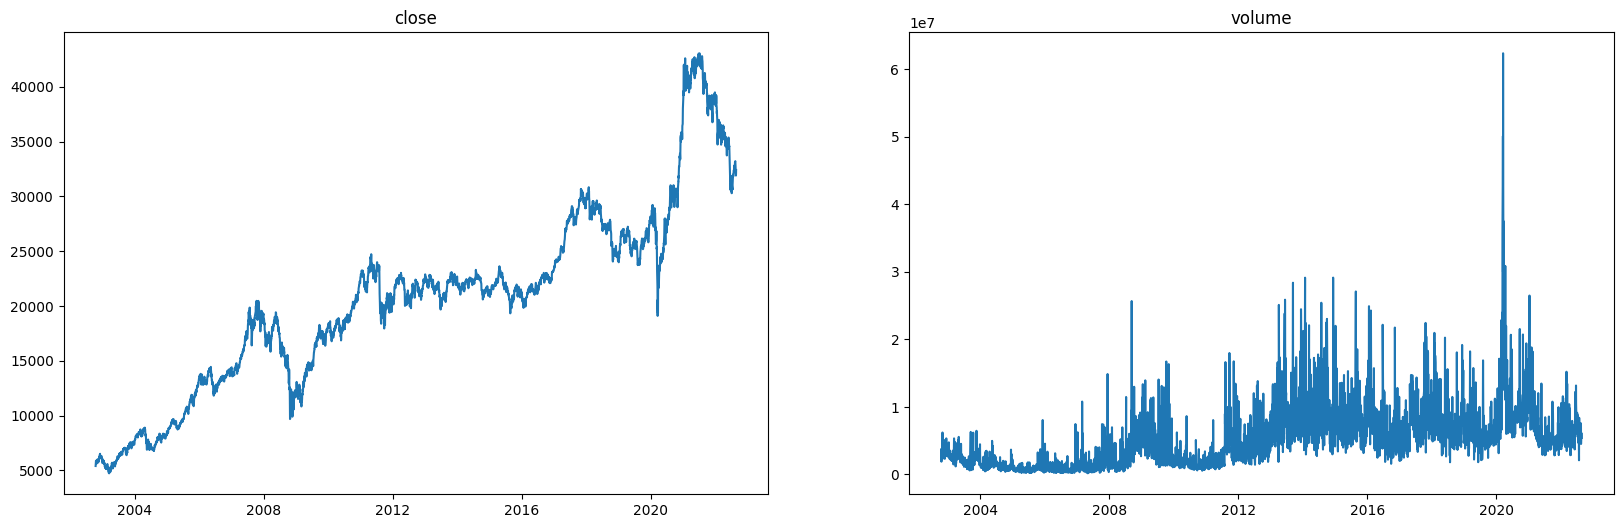

In [11]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize = (20,6))
ax1.plot(kodex.datetime,kodex.close)
ax2.plot(kodex.datetime,kodex.volume)
ax1.set_title("close")
ax2.set_title("volume")
plt.show()

- 신규 변수 생성
    - per : 전일자 대비 수익률
    - multiple_volume : 원화환산 거래량 (종가  * 거래량)

In [12]:
# per
per_list = [0,]
for i in range(1,len(kodex)):
    plus_per = ((kodex.close[i]/kodex.close[i-1])-1) * 100
    per_list.append(plus_per)
kodex["per"] = per_list

# multiple_volume
kodex["multiple_volume"] = kodex["close"] * kodex["volume"]

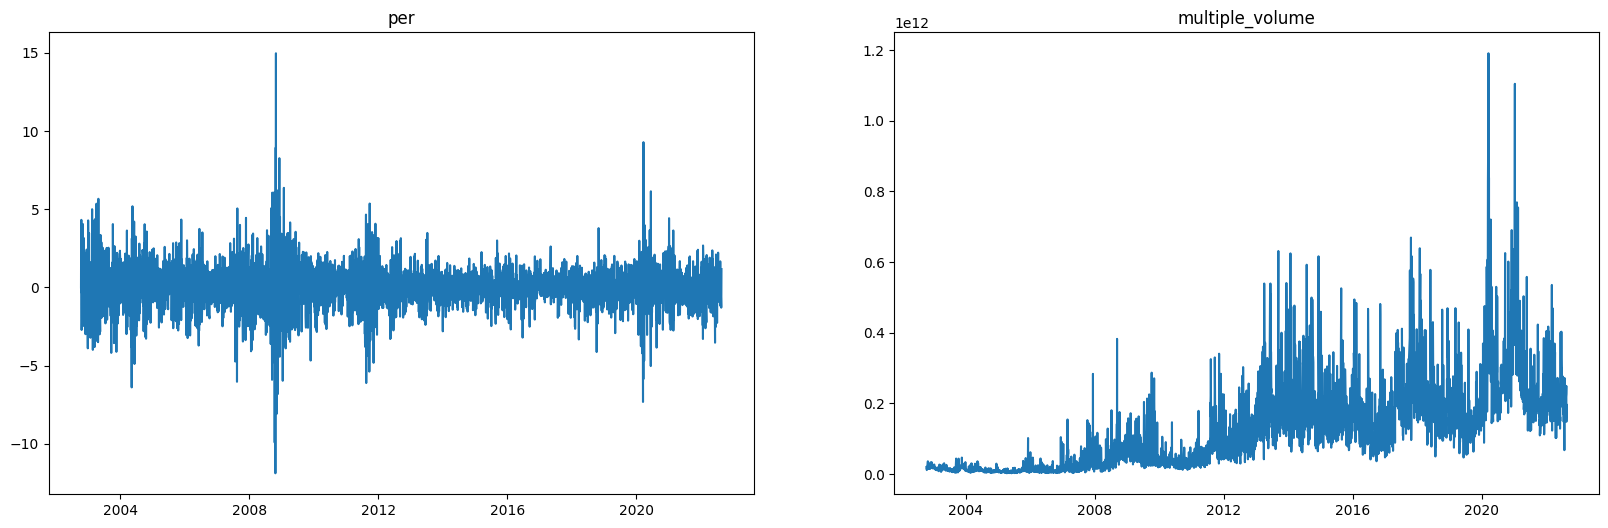

In [13]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize = (20,6))
ax1.plot(kodex.datetime,kodex.per)
ax2.plot(kodex.datetime,kodex.multiple_volume)
ax1.set_title("per")
ax2.set_title("multiple_volume")
plt.show()

## 변동성-거래량  score

### 변동성 점수
- per을 통한 변동성 점수 계산
- per의 지수가중이동편차

In [14]:
lam = 0.94
mu = kodex.per[0]
sigma = 0

In [15]:
sigma_list = []
for i in range(len(kodex.close)):
    sigma = (lam * (sigma)) + ((1-lam) * (kodex.per[i]**2))
    sigma_list.append(sigma)
    

/tmp/ipykernel_31097/3534599859.py:2: RuntimeWarning: divide by zero encountered in log
  log_sigma = np.log(sqrt_sigma)


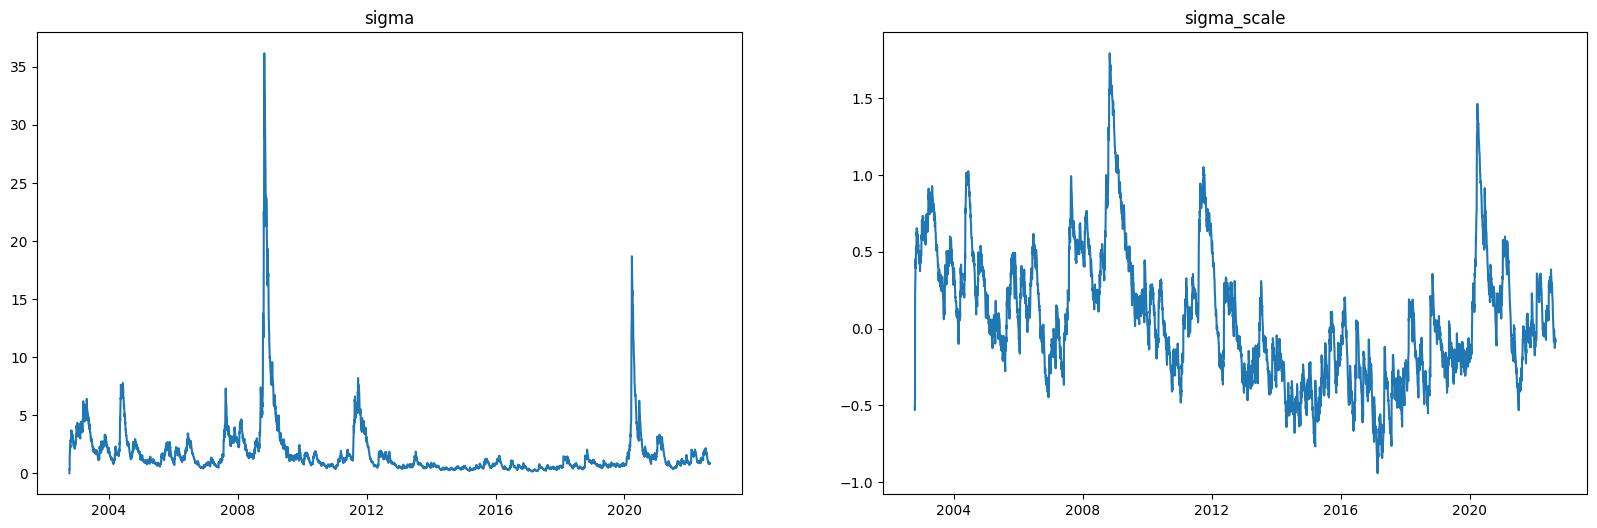

In [16]:
sqrt_sigma = np.sqrt(sigma_list)
log_sigma = np.log(sqrt_sigma)

fig,(ax1,ax2) = plt.subplots(1,2,figsize = (20,6))
ax1.plot(kodex.datetime,sigma_list)
ax2.plot(kodex.datetime,log_sigma)
ax1.set_title("sigma")
ax2.set_title("sigma_scale")
plt.show()


- (1) 변동성 점수

    -과거 365일간의 분포평균과 표준편차를 통해 점수값으로 변환한다

In [17]:
kodex["log_sigma"] = log_sigma
Volatility_list = []
for i in range(len(kodex.per)):
    
    # data setting
    tmp_data = kodex[(i-365):i]
    
    # data condition
    if len(tmp_data) == 365 :
        
        sigma365 = tmp_data.log_sigma
        
        mu_setting = np.mean(sigma365)
        std_setting = np.std(sigma365)
        
        set1 = np.max([-4, ((sigma365.values[364] -  mu_setting)/std_setting) ])
        set2 = np.min([set1,4])
        Volatility_list.append(set2)
        

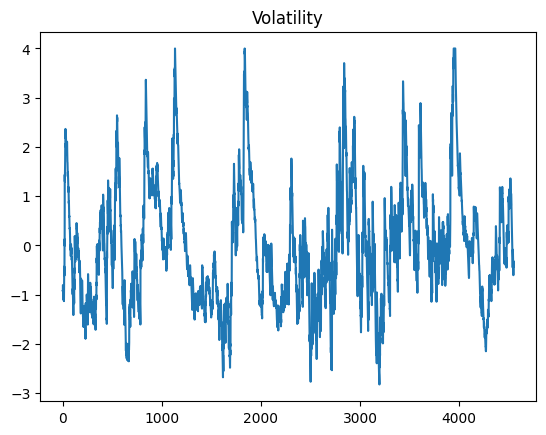

In [18]:
plt.plot(Volatility_list)
plt.title("Volatility")
plt.show()

### 거래량 점수
- 원화환산 거래량 값을 사용해 거래량 점수를 계산한다
- 단기 거래량과 장기 거래량의 값을 사용한다
- lambda 를 통해서 지수가중이동평균의 가중치를 변경한다
    - 첫 N일의 정보포함률이 63.2%로 수렴하는 수치

In [19]:
lambda_20 = 1-(1/20)
lambda_60 = 1-(1/60)
print(lambda_20)
print(lambda_60)

0.95
0.9833333333333333


- 원화한산 거래량의 단기,장기 가중이동평균

In [20]:
volume_sigma20_list = []
volume_sigma60_list = []

for i in range(len(kodex.multiple_volume)):
    
    # list set
    list1 = []
    list2 = []
    
    # sumation
    for j in range(i+1):
        volume_sigma_20 = (1-lambda_20) * (lambda_20**j) * kodex.multiple_volume[i-j]
        volume_sigma_60 = (1-lambda_60) * (lambda_60**j) * kodex.multiple_volume[i-j]
        list1.append(volume_sigma_20)
        list2.append(volume_sigma_60)
        
    V20 = np.sum(list1)
    V60 = np.sum(list2)
    volume_sigma20_list.append(V20)
    volume_sigma60_list.append(V60)
        

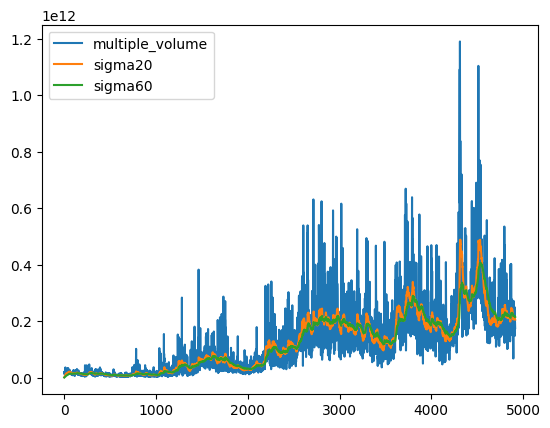

In [21]:
plt.plot(range(0,len(volume_sigma20_list)),kodex.multiple_volume,
         range(0,len(volume_sigma20_list)),volume_sigma20_list, 
         range(0,len(volume_sigma20_list)), volume_sigma60_list)
plt.legend(["multiple_volume","sigma20", "sigma60"])
plt.show()

- 거래량 점수
    - 단기거래량과 장기거래량의 로그스케일 이격도를 통해 점수를 계산한다
    - 두개 이격도의 평균을 통해 -4~4까지의 스케일을 가지는 거래량 점수를 계산한다

In [22]:
V_20 = np.log(kodex.multiple_volume/volume_sigma20_list)
V_60 = np.log(kodex.multiple_volume/volume_sigma60_list)

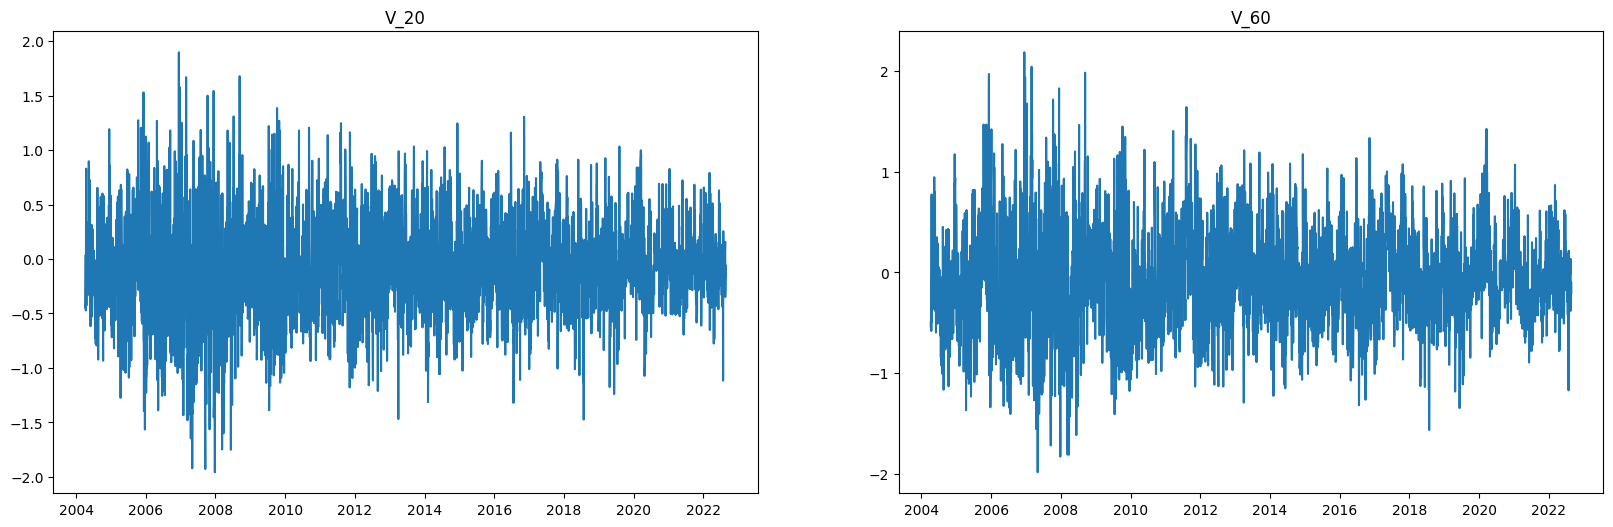

In [23]:

fig,(ax1,ax2) = plt.subplots(1,2,figsize = (20,6))
ax1.plot(kodex.datetime[365:],V_20[365:])
ax2.plot(kodex.datetime[365:],V_60[365:])
ax1.set_title("V_20")
ax2.set_title("V_60")
plt.show()


In [24]:
Volume_list = []
for i in range(len(V_20)):
    set1 = np.max([-4, ((V_20[i]+V_60[i])/2)])
    set2 = np.min([set1, 4])
    Volume_list.append(set2)

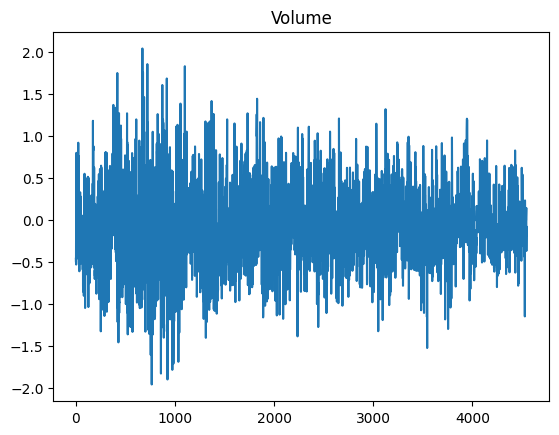

In [25]:
plt.plot(Volume_list[365:])
plt.title("Volume")
plt.show()

### 변동성-거래량 점수

- 위 단계에서 계산한 (1)Voltaility 와 (2)Volume 스코어의 값을 평균내어 변동성 거래량 점수를 계산한다 
- 점수의 스케일은 0~1까지의 스케일이다.

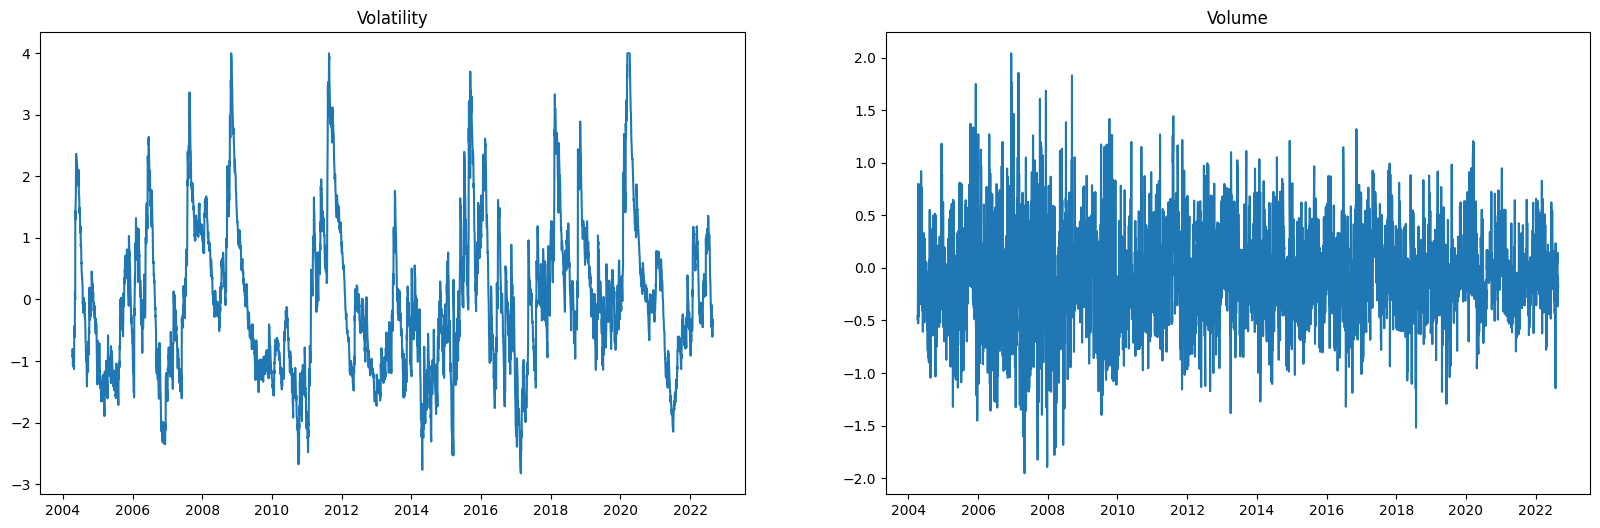

In [26]:

fig,(ax1,ax2) = plt.subplots(1,2,figsize = (20,6))
ax1.plot(kodex.datetime[365:],Volatility_list)
ax2.plot(kodex.datetime[365:],Volume_list[365:])
ax1.set_title("Volatility")
ax2.set_title("Volume")
plt.show()


In [27]:
S1_list = []
for i in range(len(Volatility_list)):
    set1 = np.max([-4,float(Volatility_list[i] + Volume_list[365:][i])])
    set2 = np.min([ 4, set1])
    set3 = set2/8 + 0.5
    S1_list.append(set3)

- 변동성 - 거래량 점수

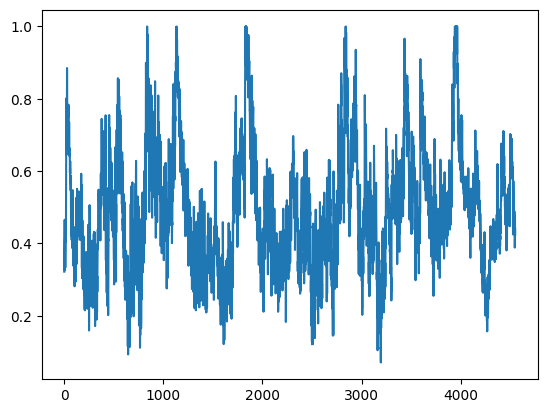

In [28]:
plt.plot(S1_list)

## 모멘텀 score

- kodex 종가의 가중이동평균을 계산한후 실제가와 이동평균값의 이격도를 통해 모멘텀 점수를 계산한다
- 변동성-거래량 점수에 의해 장기이평선 단기이평선 가중을 변경한다 
- 시장의 변동성과 거래량이 높은 (거래량 급등/급락)하는 시장에서 투자자들은 단기간 추세에 민감하게 반응
- 변동성 거래량 점수가 높다면 단기 가중치를 더욱 크게 한다

In [29]:
short_alpha = [(i*9)+1 for i in S1_list]
long_alpha = [10 - ((i*9)+1) for i in S1_list]

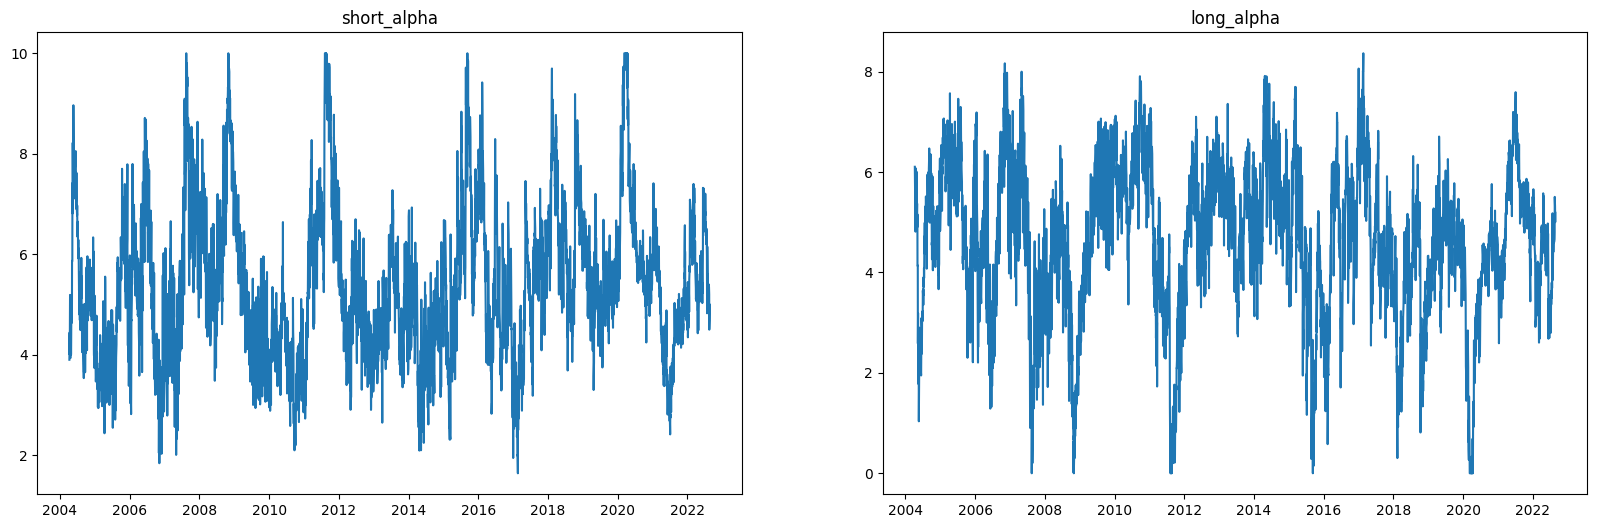

In [30]:

fig,(ax1,ax2) = plt.subplots(1,2,figsize = (20,6))
ax1.plot(kodex.datetime[365:],short_alpha)
ax2.plot(kodex.datetime[365:],long_alpha)
ax1.set_title("short_alpha")
ax2.set_title("long_alpha")
plt.show()


- kodex 종가의 가중이동평균값을 계산한다

In [31]:
lambda_30 = 1-(1/30)
lambda_7 = 1-(1/7)

In [32]:
close_mu30_list = []
close_mu7_list = []
for i in range(len(kodex.close)):
    
    # list set
    list1 = []
    list2 = []
    
    # sumation
    for j in range(i+1):
        close_mu_30 = (1-lambda_30) * (lambda_30**j) * kodex.close[i-j]
        close_mu_7 = (1-lambda_7) * (lambda_7**j) * kodex.close[i-j]
        list1.append(close_mu_30)
        list2.append(close_mu_7)
        
    V30 = np.sum(list1)
    V7 = np.sum(list2)
    close_mu30_list.append(V30)
    close_mu7_list.append(V7)
        

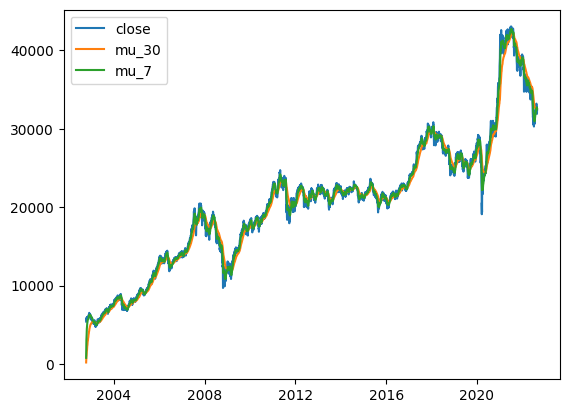

In [33]:
plt.plot(kodex.datetime,kodex.close,
         kodex.datetime,close_mu30_list,
         kodex.datetime,close_mu7_list)

plt.legend(["close","mu_30", "mu_7"])
plt.show()


- 이격도를 계산한다
    - long term 이격도는 큰 추세에서의 점수를 더 잘 반영한다. 
    - short term 이격도는 작은 로컬한 지역에서의 점수를 더 잘 반영한다.

In [34]:
X_short = (kodex.close - close_mu7_list) / close_mu7_list
X_long = (kodex.close - close_mu30_list) / close_mu30_list

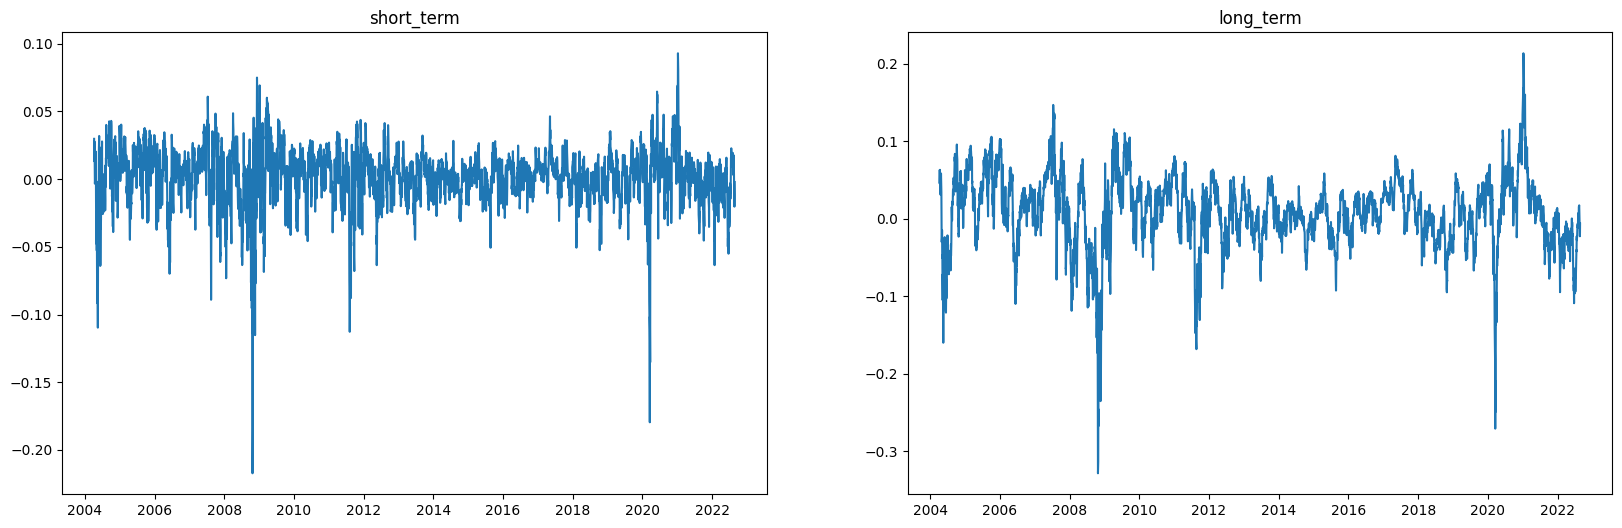

In [35]:

fig,(ax1,ax2) = plt.subplots(1,2,figsize = (20,6))
ax1.plot(kodex.datetime[365:],X_short[365:])
ax2.plot(kodex.datetime[365:],X_long[365:])
ax1.set_title("short_term")
ax2.set_title("long_term")
plt.show()


- 변동성거래량 점수의 가중치를 활용하여 모멘텀 점수를 계산한다
    - C는 점수의 스케일을 조정하기 위한 상수 파라미터

In [36]:
products_short = [a * b for a, b in zip(short_alpha, X_short[365:])]
products_long = [a * b for a, b in zip(long_alpha, X_long[365:])]
product_momentum = [a+b for a,b in zip(products_short, products_long)]

In [37]:
C = 16.387308
S2_list = [(i*C)/10 for i in product_momentum]

- 모멘텀 점수

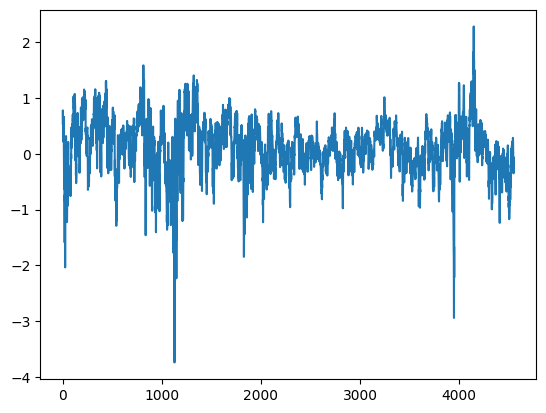

In [38]:
plt.plot(S2_list)

## FG score

- S1_list : 변동성 거래량 점수
    - 스케일 : 0 ~ 1 
    
- S2_list : 모멘텀 점수
    - 스케일 : 실수 범위

- S1_list : FG score
    - 공포탐욕지수
    
- 케이스별 시나리오
    - case1 : 변동성이 큰 상태에서 모멘텀도 크다
        - 탐욕지수가 매우 커진다
    - case2 : 변동성이 작은 상태에서 모멘텀도 크다
        - 탐욕지수가 비교적 상승하고자 한다
        - 지수에 영향이 별로 없다 (0.5에 가깝게 나타난다) 
    - case3 : 변동성이 큰 상태에서 모멘텀이 작다
        - 탐욕지수가 매우 작아진다
    - case4 : 변동성이 작은상태에서 모멘텀이 크다
        - 탐욕지수가 비교적 하락하고자 한다
        - 지수에 영향이 별로 없다 (0.5에 가깝게 나타난다)
        
- 비고
    - 변동성 거래량 점수
        - 0~1이기 때문에 중립에서 양분되어 공포와 탐욕이 커질수록 커지는 값이다 
    - 모멘텀 점수
        - 실수의 범위에서 이격도를 뜻한다

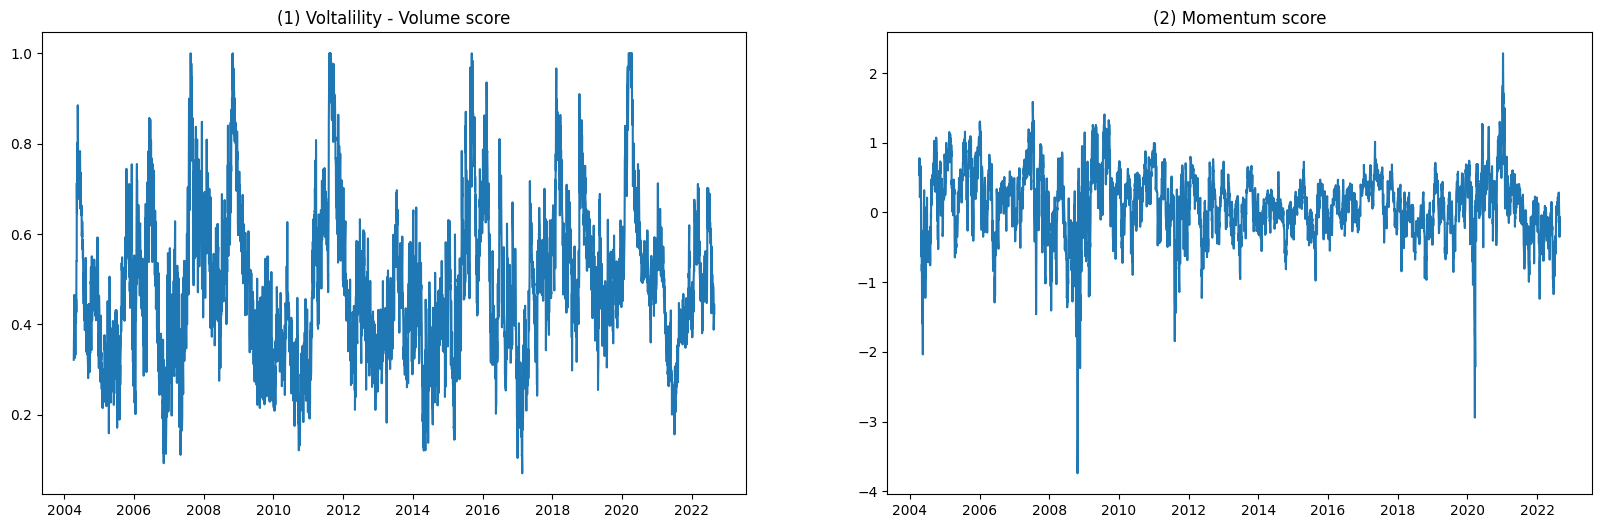

In [39]:

fig,(ax1,ax2) = plt.subplots(1,2,figsize = (20,6))
ax1.plot(kodex.datetime[365:],S1_list)
ax2.plot(kodex.datetime[365:],S2_list)
ax1.set_title("(1) Voltalility - Volume score")
ax2.set_title("(2) Momentum score")
plt.show()


- (1)변동성-거래량 점수와 (2)모멘텀 점수를 곱한다
- 곱한 값을 로지스틱 함수에 대입하여 최종 공포탐욕지수 스코어를 산출한다

In [40]:
S_list = [-(a*b) for a,b in zip(S1_list, S2_list)]
FG_score = [1/(1+np.exp(i)) for i in S_list]

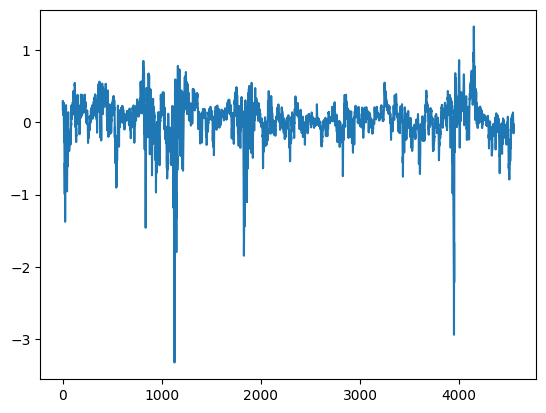

In [41]:
plt.plot([(a*b) for a,b in zip(S1_list, S2_list)])

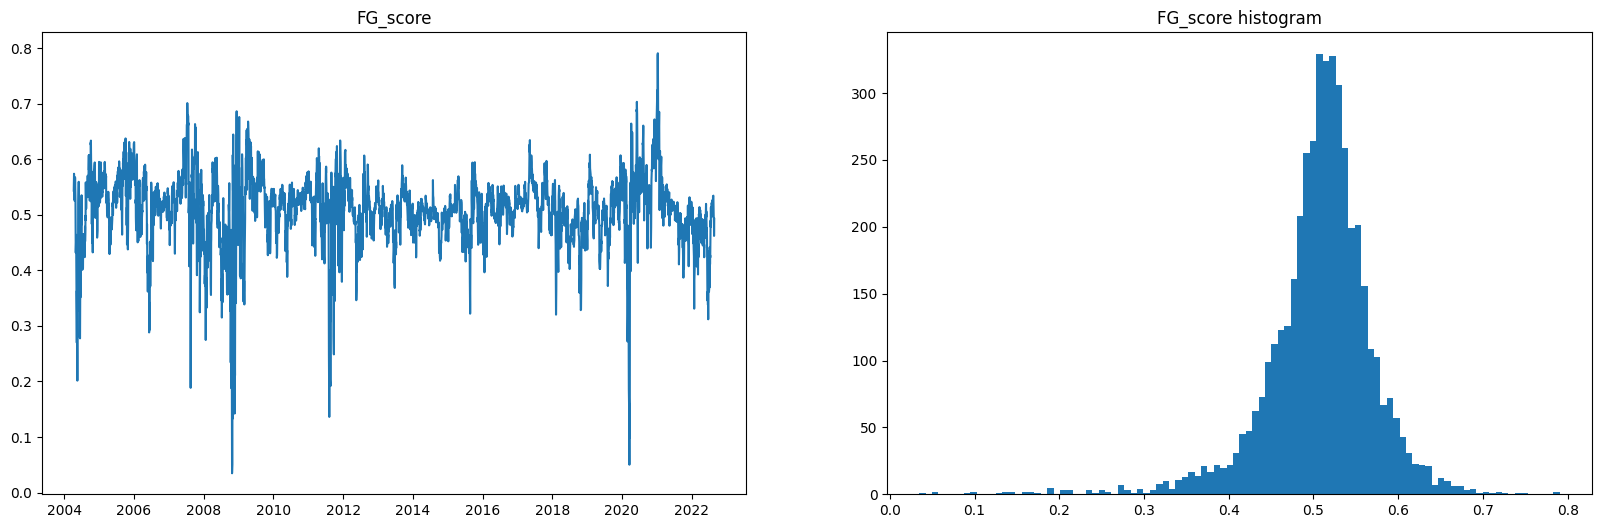

In [42]:

fig,(ax1,ax2) = plt.subplots(1,2,figsize = (20,6))
ax1.plot(kodex.datetime[365:],FG_score)
ax2.hist(FG_score, bins = 100)
ax1.set_title("FG_score")
ax2.set_title("FG_score histogram")
plt.show()


## 조건

In [43]:
res = [idx for idx, val in enumerate(FG_score) if val<=0.1]

In [44]:
itemgetter(*res)(datetime_list[365:])

(datetime.date(2008, 10, 23),
 datetime.date(2008, 10, 24),
 datetime.date(2008, 10, 27),
 datetime.date(2020, 3, 18),
 datetime.date(2020, 3, 19),
 datetime.date(2020, 3, 23))

In [45]:
res = [idx for idx, val in enumerate(FG_score) if val>=0.7]

In [46]:
itemgetter(*res)(datetime_list[365:])

(datetime.date(2007, 7, 13),
 datetime.date(2020, 6, 5),
 datetime.date(2021, 1, 4),
 datetime.date(2021, 1, 5),
 datetime.date(2021, 1, 7),
 datetime.date(2021, 1, 8),
 datetime.date(2021, 1, 11),
 datetime.date(2021, 1, 12),
 datetime.date(2021, 1, 13),
 datetime.date(2021, 1, 14))

## Plotting

In [47]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [48]:
final_data = pd.DataFrame({'date': datetime_list[365:],
                          'close': kodex['close'][365:],
                          'FG_score': FG_score})

In [49]:
px.line(final_data, x = 'date', y='FG_score',
        hover_data={"date": "|%B %d, %Y"})

In [50]:
fig = make_subplots(specs = [[{'secondary_y':True}]])
fig.add_trace(
    go.Scatter(x=final_data.date, y = final_data.FG_score, name = "FG_score"
               , hovertemplate = 'date = %{x}<br>'+
                                 'value = %{y}'),
    secondary_y = False,
)
fig.add_trace(
    go.Scatter(x=final_data.date, y = final_data.close, name = "kodex200"
               , hovertemplate = 'date = %{x}<br>'+
                                 'value = %{y}'),
    secondary_y = True,
)
fig.add_trace(
    go.Scatter(x=final_data.date, y = [0.5]*4550, name = 'middle'),
    secondary_y = False,
)

fig.update_layout(
    title_text = "FG score", hovermode="x")
fig.update_xaxes(title_text = "date", rangeslider_visible = True)
fig.update_yaxes(title_text = "FG_score", secondary_y = False)
fig.update_yaxes(title_text = "stock_close", secondary_y = True)
# specific line"

fig.show()

In [48]:
fig = make_subplots(specs = [[{'secondary_y':True}]])
fig.add_trace(
    go.Scatter(x=final_data.date, y = final_data.FG_score, name = "FG_score"
               , hovertemplate = 'date = %{x}<br>'+
                                 'value = %{y}'),
    secondary_y = False,
)
fig.add_trace(
    go.Scatter(x=final_data.date, y = S2_list, name = "momentum"
               , hovertemplate = 'date = %{x}<br>'+
                                 'value = %{y}'),
    secondary_y = True,
)
fig.add_trace(
    go.Scatter(x=final_data.date, y = [0.5]*4550, name = 'middle'),
    secondary_y = False,
)

fig.update_layout(
    title_text = "FG score", hovermode="x")
fig.update_xaxes(title_text = "date", rangeslider_visible = True)
fig.update_yaxes(title_text = "FG_score", secondary_y = False)
fig.update_yaxes(title_text = "momentum_score", secondary_y = True)
# specific line

fig.show()

In [49]:
fig = make_subplots(specs = [[{'secondary_y':True}]])
fig.add_trace(
    go.Scatter(x=final_data.date, y = final_data.FG_score, name = "FG_score"
               , hovertemplate = 'date = %{x}<br>'+
                                 'value = %{y}'),
    secondary_y = False,
)
fig.add_trace(
    go.Scatter(x=final_data.date, y = S2_list, name = "momentum"
               , hovertemplate = 'date = %{x}<br>'+
                                 'value = %{y}'),
    secondary_y = True,
)
fig.add_trace(
    go.Scatter(x=final_data.date, y = [0.5]*4550, name = 'middle'),
    secondary_y = False,
)

fig.update_layout(
    title_text = "FG score", hovermode="x")
fig.update_xaxes(title_text = "date", rangeslider_visible = True)
fig.update_yaxes(title_text = "FG_score", secondary_y = False)
fig.update_yaxes(title_text = "momentum_score", secondary_y = True)
# specific line

fig.show()

In [50]:
fig = make_subplots(specs = [[{'secondary_y':True}]])
fig.add_trace(
    go.Scatter(x=final_data.date, y = final_data.FG_score, name = "FG_score"
               , hovertemplate = 'date = %{x}<br>'+
                                 'value = %{y}'),
    secondary_y = False,
)
fig.add_trace(
    go.Scatter(x=final_data.date, y = final_data.close, name = "kodex200"
               , hovertemplate = 'date = %{x}<br>'+
                                 'value = %{y}'),
    secondary_y = True,
)
fig.add_trace(
    go.Scatter(x=final_data.date, y = [0.5]*4550, name = 'middle'),
    secondary_y = False,
)

fig.update_layout(
    title_text = "FG score", hovermode="x")
fig.update_xaxes(title_text = "date", rangeslider_visible = True)
fig.update_yaxes(title_text = "FG_score", secondary_y = False)
fig.update_yaxes(title_text = "stock_close", secondary_y = True)
# specific line

fig.show()